# TGDS Model using Feature Engineering

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
from numba import cuda 

import src.data.data_preprocessing as util
import src.models.lstm_model as lstm

os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.compat.v1.set_random_seed(1)

2022-09-22 12:52:58.865898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 12:52:58.982678: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-22 12:52:59.388656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:$LD_LIBRARY_PATH:/home/i40/bielskip/miniconda3/envs/battery-system/lib/:/home/i40/bielskip/miniconda3/envs/battery-system/lib/
2022-09-22 12:52:59.388710: W tensorflow/stream_executor/platfo

### Set Hyperparameters

In [4]:
# load general hyperparameters
HYPER_PARAMS =  np.load('../../../models/training_setup/hyperparameters.npy', allow_pickle=True)
HYPER_PARAMS = HYPER_PARAMS.item()

# add aditional model-spefic hyperparameters
model_hyperparameters = {
    'n_features': 2,       # number of input features
    'd_t': 0.25,           # current integration factor
}

# update hyperparameters
HYPER_PARAMS.update(model_hyperparameters)

### Prepare Training/Validation/Test Data

In [5]:
# load training sets dictionary
TRAINING_SETS =  np.load('../../../models/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()

# select correct training set
training_sets = TRAINING_SETS['10A_all']

# create training data
train_data = []
for set in training_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat']
    train_data += set_repeat
train_data = np.array(train_data)

# select first profile for validation
validation_profile = [train_data[0]] 

# select arbitrary profile for testing
test_profile = np.random.choice(train_data, 1) 

# prepare input data
X_train, y_train, scalers_train = util.prepare_feature_engineering_input(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_validation, y_validation, _ = util.prepare_feature_engineering_input(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_test, y_test, _ = util.prepare_feature_engineering_input(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (46750, 100, 2)  Output/Label: (46750, 1)
Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (1650, 100, 2)  Output/Label: (1650, 1)


### Initialize and Train Model

In [6]:
lstm = lstm.Model()
lstm.initialize(HYPER_PARAMS)

2022-09-22 12:53:02.915592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 12:53:02.953334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 12:53:02.953504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 12:53:02.954161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "Black_Box_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10600     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                5680      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 16,301
Trainable params: 16,301
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5


2022-09-21 10:43:24.287798: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   3/1461 [..............................] - ETA: 36s - loss: 0.0227 - mse: 0.0227 - mae: 0.1305  

2022-09-21 10:43:24.854874: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1461/1461 [==============================] - 36s 24ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0300
Epoch 2/5
1461/1461 [==============================] - 35s 24ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0290
Epoch 3/5
1461/1461 [==============================] - 35s 24ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0290
Epoch 4/5
1461/1461 [==============================] - 35s 24ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0289
Epoch 5/5
1461/1461 [==============================] - 35s 24ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0289
Training time: 177.042s


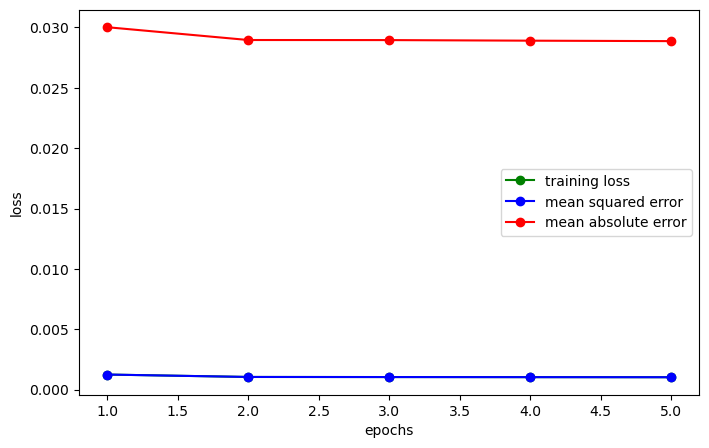

INFO:tensorflow:Assets written to: ../../../models/TGDS/9348/assets


INFO:tensorflow:Assets written to: ../../../models/TGDS/9348/assets


In [5]:
_, fig = lstm.train(X_train, y_train, scalers_train)

# save model and hyperparameters
MODEL_ID = str(np.random.randint(10000))

lstm.model.save('../../../models/TGDS/' + str(MODEL_ID))
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
fig.savefig('../../../reports/figures/theory_guided_charge-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

Validation Profile: ['Profile 10A']
Test Profile: ['Profile 10A Run 080618']
1461/1461 [==============================] - 12s 9ms/step
Prediction time on Training Set:  12.439s
47/47 [==============================] - 0s 9ms/step
Prediction time on Validation Set:  0.413s
46/46 [==============================] - 0s 9ms/step
Prediction time on Test Set:  0.404s
###########################################################
            Training    Validation     Test
--------  ----------  ------------  -------
MSE (μV)    114.4         287.9     77.7
MAE (V)       0.0098        0.0168   0.0074
MaxE (V)      0.022         0.022    0.0145
###########################################################


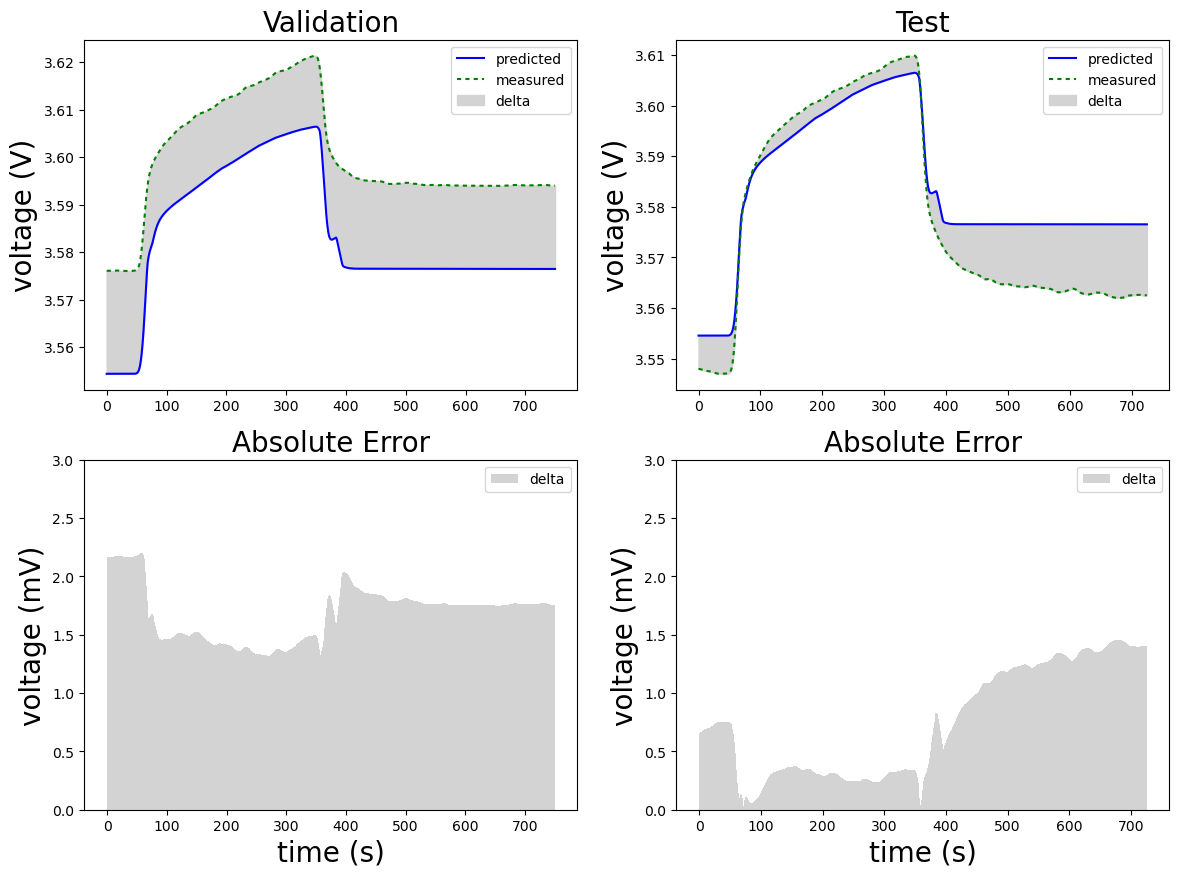

In [6]:
print('Validation Profile:', validation_profile)
print('Test Profile:', test_profile)

yhat_train_unscaled, _, _, fig = lstm.test(X_train, y_train, X_validation, y_validation, X_test, y_test, scalers_train)

# save plots and predicted sequences
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/predictions', yhat_train_unscaled)
fig.savefig('../../../reports/figures/theory_guided_charge-' + str(MODEL_ID) + '-validation&test_profiles.png')

### Prepare Data for Use Cases

In [7]:
# load test sets dictionary
TEST_SETS =  np.load('../../../models/training_setup/test_sets.npy', allow_pickle=True)
TEST_SETS = TEST_SETS.item()

# select needed test profiles
test_profiles_usecase_1 = TEST_SETS['Reproduction']
test_profiles_usecase_2 = TEST_SETS['Abstraction']
test_profiles_usecase_3 = TEST_SETS['Generalization']

# prepare input data
X_case_1, y_case_1, _ = util.prepare_feature_engineering_input(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_2, y_case_2, _ = util.prepare_feature_engineering_input(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_3, y_case_3, _ = util.prepare_feature_engineering_input(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (3100, 100, 2)  Output/Label: (3100, 1)
Input: (1600, 100, 2)  Output/Label: (1600, 1)


### Test Model on Use Cases

Use Case 1: ['Profile 10A']
Use Case 2: ['Profile 10A 3x']
Use Case 3: ['Profile -10A']
1461/1461 [==============================] - 12s 8ms/step
Prediction time on Training Set:  12.429s
47/47 [==============================] - 0s 8ms/step
Prediction time on Use Case 1:  0.411s
97/97 [==============================] - 1s 8ms/step
Prediction time on Use Case 2:  0.834s
50/50 [==============================] - 0s 8ms/step
Prediction time on Use Case 3:  0.436s
##############################################################
             Training    Use Case 1    Use Case 2    Use Case 3
---------  ----------  ------------  ------------  ------------
MSE  (μV)    114.4         287.9         980.8         128.7
MAE  (V)       0.0098        0.0168        0.0225        0.0097
MaxE (V)       0.022         0.022         0.0676        0.0213
##############################################################


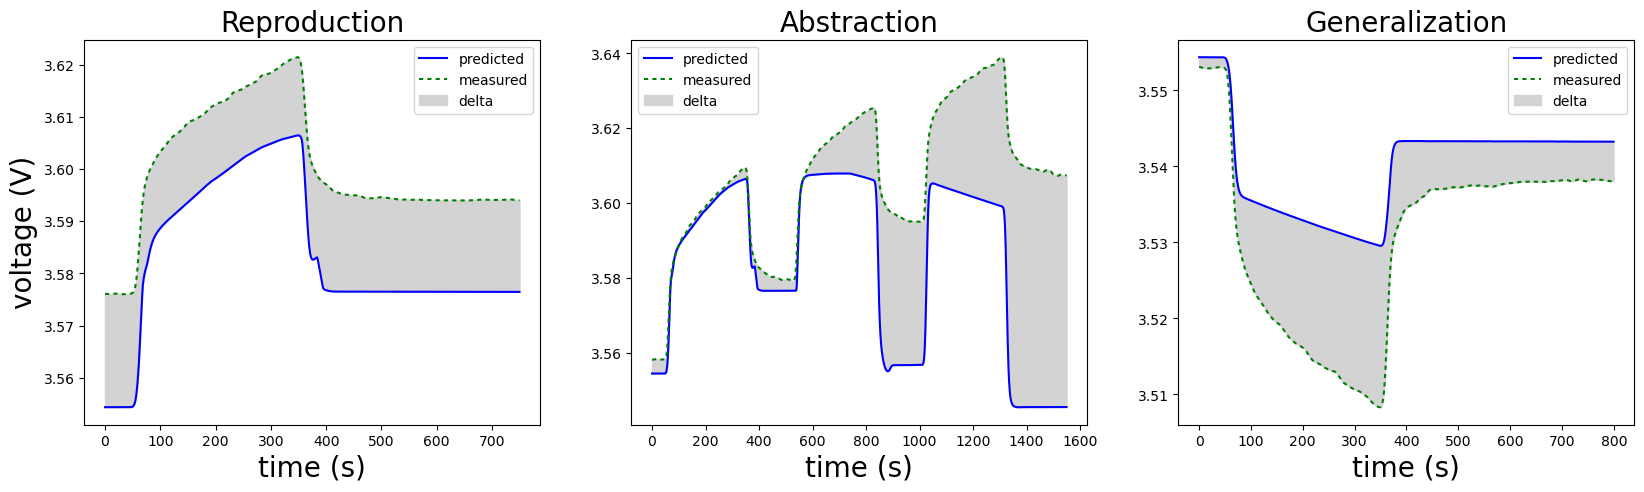

In [8]:
print('Use Case 1:', test_profiles_usecase_1)
print('Use Case 2:', test_profiles_usecase_2)
print('Use Case 3:', test_profiles_usecase_3)

train_mse, case_1_mse, case_2_mse, case_3_mse, fig = lstm.test_usecases(X_train, y_train, X_case_1, y_case_1, X_case_2, y_case_2, X_case_3, y_case_3, scalers_train)

In [9]:
fig.savefig('../../../reports/figures/data_baseline-' + str(MODEL_ID) + '-use_cases.png')
columns = ["Name", "Timestamp", "Model ID", "Train MSE", "Case 1 MSE", "Case 2 MSE", "Case 3 MSE"]
df = pd.DataFrame(columns=columns)

timestamp = datetime.datetime.now().isoformat(sep=" ", timespec="seconds")

new_df = pd.DataFrame([["Feature Engineering", timestamp, MODEL_ID, train_mse, case_1_mse, case_2_mse, case_3_mse]], columns=columns)

df = pd.concat(([df, new_df]))
df.to_csv('../../../reports/results/experiments.csv', mode='a', float_format='%.10f', index=False, header=False)

In [10]:
cuda.select_device(0)
cuda.close()